## 利用神经网络识别手写字体

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import scipy.io #用于读取 *.mat文件
import scipy.misc #用于把矩阵数据以图片方式展示出来
import matplotlib.cm as cm #展示图片
import random #随机选择
from scipy.special import expit #Sigmoid函数

多分类问题

In [2]:
datafile = 'data/ex3data1.mat'
mat = scipy.io.loadmat(datafile)
X, y = mat['X'], mat['y']
#同常，X需要补一个常数项1
X = np.insert(X,0,1,axis=1)
print("X.shape:{};y.shape:{};Unique elements in y:{})".format(X.shape,y.shape,np.unique(y)))
#X是5000张图片，每张图片是形状为(400,1)的数据（20*20）
#y是每张图片对应的数字，1-10,10代表手写字体“0”

X.shape:(5000, 401);y.shape:(5000, 1);Unique elements in y:[ 1  2  3  4  5  6  7  8  9 10])


In [3]:
def getDatumImg(row):
    width, height = 20, 20
    square = row[1:].reshape(width,height)
    return square.T
    
def displayData(indices_to_display = None):
    width, height = 20, 20
    nrows, ncols = 10, 10
    if not indices_to_display:
        indices_to_display = random.sample(range(X.shape[0]), nrows*ncols)
        
    big_picture = np.zeros((height*nrows,width*ncols))
    
    irow, icol = 0, 0
    for idx in indices_to_display:
        if icol == ncols:
            irow += 1
            icol  = 0
        iimg = getDatumImg(X[idx])
        big_picture[irow*height:irow*height+iimg.shape[0],icol*width:icol*width+iimg.shape[1]] = iimg
        icol += 1
    fig = plt.figure(figsize=(6,6))
    img = scipy.misc.toimage( big_picture )
    plt.axis('off')
    plt.imshow(img,cmap = cm.Greys_r)

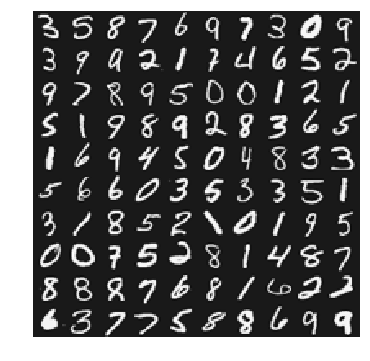

In [4]:
displayData()

向量化逻辑回归

In [5]:
def h(mytheta,myX):
    return expit(np.dot(myX, mytheta))

def computeCost(mytheta,myX,myy):
    m = len(X) #5000
    term1 = np.dot(-np.array(myy).T,np.log(h(mytheta,myX)))#shape(1,401)
    term2 = np.dot((1-np.array(myy)).T,np.log(1-h(mytheta,myX)))#shape(1,401)
    return float((1./m) * np.sum(term1 - term2) )

"one-vs-all"多分类

In [6]:
initial_theta = np.zeros((X[1].size,1))

In [7]:
def costGradient(mytheta,myX,myy):
    m = myX.shape[0]
    beta = h(mytheta,myX)-myy.T #shape: (5000,1)
    grad = (1./m)*np.dot(myX.T,beta) #shape: (401, 5000)
    return grad #shape: (401, 1)

In [8]:
from scipy import optimize
#theta = optimize.fmin(computeCost,initial_theta, args=(X, y))

def optimizeTheta(mytheta,myX,myy):
    result = optimize.fmin_cg(computeCost, fprime=costGradient, x0=mytheta, \
                              args=(myX, myy), maxiter=50, disp=False,\
                              full_output=True)
    return result[0], result[1]

def buildTheta():
    initial_theta = np.zeros((X[1].size,1))
    Theta = np.zeros((X[1].size,10))
    for i in range(10):
        iclass = i if i else 10
        logic_Y = np.array([1 if x == iclass else 0 for x in y])
        itheta, imincost = optimizeTheta(initial_theta, X, logic_Y)
        Theta[:,i] = itheta
        print("正在优化手写数字 %d..."%i)
    print('done')
    return Theta

In [9]:
Theta = buildTheta()

正在优化手写数字 0...
正在优化手写数字 1...
正在优化手写数字 2...
正在优化手写数字 3...
正在优化手写数字 4...
正在优化手写数字 5...
正在优化手写数字 6...
正在优化手写数字 7...
正在优化手写数字 8...
正在优化手写数字 9...
done


In [10]:
def predictOneVsAll(myTheta,myrow):
    classes = [10] + list(range(1,10))
    hypots  = [0]*len(classes)
    #Compute a hypothesis for each possible outcome
    #Choose the maximum hypothesis to find result
    for i in range(len(classes)):
        hypots[i] = h(myTheta[:,i],myrow)
    return classes[np.argmax(np.array(hypots))]    

In [11]:
# "You should see that the training set accuracy is about 94.9%"
n_correct, n_total = 0., 0.
incorrect_indices = []
for irow in range(X.shape[0]):
    n_total += 1
    if predictOneVsAll(Theta,X[irow]) == y[irow]: 
        n_correct += 1
    else: incorrect_indices.append(irow)
print("Training set accuracy: {:.1f}%".format(100*(n_correct/n_total)))

Training set accuracy: 89.1%


In [22]:
predictOneVsAll(Theta,X[1600])

3

In [24]:
scipy.misc.toimage(X[1600][1:].reshape(20,20).T)

### 神经网络

模型表示

In [15]:
#我们已经有现成的模型参数(Θ(1),Θ(2)) 
datafile = 'data/ex3weights.mat'
mat = scipy.io.loadmat( datafile )
Theta1, Theta2 = mat['Theta1'], mat['Theta2']
print("Theta1 has shape:",Theta1.shape)
print("Theta2 has shape:",Theta2.shape)

Theta1 has shape: (25, 401)
Theta2 has shape: (10, 26)


前向传播和预测

![](data/network.png)

In [39]:
def propagateForward(row,Thetas):
    feature = np.mat(row)
    for i in range(len(Thetas)):      
        theta = Thetas[i]
        z = np.dot(feature, theta.T)
        a = expit(z)
        if i == len(Thetas)-1:
            return a
        a = np.insert(a,0,1,axis=1)#增加偏置项
        feature = a

In [44]:
def predictNN(row,Thetas):
    """
    Function that takes a row of features, propagates them through the
    NN, and returns the predicted integer that was hand written
    """
    classes = list(range(1,10)) + [10]
    output = propagateForward(row,Thetas)
    return classes[np.argmax(np.array(output))]

In [47]:
myThetas = Theta1, Theta2

In [51]:
# "You should see that the accuracy is about 97.5%"
myThetas = [ Theta1, Theta2 ]
n_correct, n_total = 0., 0.
incorrect_indices = []
#Loop over all of the rows in X (all of the handwritten images)
#and predict what digit is written. Check if it's correct, and
#compute an efficiency.
for irow in range(X.shape[0]):
    n_total += 1
    if predictNN(X[irow],myThetas) == int(y[irow]): 
        n_correct += 1
    else: incorrect_indices.append(irow)
print("Training set accuracy: {:0.1f}%".format(100*(n_correct/n_total)))

Training set accuracy: 97.5%
